In [1]:
from util import *
import random
import tensorflow

# Prompt for mode
mode = "load"


# Set file names
file_train_instances = "train_stances.csv"
file_train_bodies = "train_bodies.csv"
file_test_instances = "test_stances_unlabeled.csv"
file_test_bodies = "test_bodies.csv"
file_predictions = 'predictions_test.csv'


# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epoch = 30


# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
n_train = len(raw_train.instances)


# Process data sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)




C:\Users\rushi\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(hidden_size, input_shape=(feature_size,), activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(target_size, activation = 'softmax'))
model.add(tf.keras.layers.Dropout(0.1))

In [3]:
opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
scce = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=opt, loss=scce, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [4]:
x_val = train_set[-5000:]
y_val = train_stances[-5000:]
x_train = train_set[:-5000]
y_train = train_stances[:-5000]

In [5]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
test_set = np.asarray(test_set)

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size_train,
    epochs=epoch,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Train on 44972 samples, validate on 5000 samples
Epoch 1/30
44972/44972 [==============================] - 8s 170us/sample - loss: 1.5116 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.2935 - val_sparse_categorical_accuracy: 0.9198
Epoch 2/30
44972/44972 [==============================] - 3s 75us/sample - loss: 0.6596 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.1993 - val_sparse_categorical_accuracy: 0.9528
Epoch 3/30
44972/44972 [==============================] - 3s 69us/sample - loss: 0.4563 - sparse_categorical_accuracy: 0.8709 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9618
Epoch 4/30
44972/44972 [==============================] - 3s 62us/sample - loss: 0.3821 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.1512 - val_sparse_categorical_accuracy: 0.9688
Epoch 5/30
44972/44972 [==============================] - 3s 65us/sample - loss: 0.3419 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.1483 - val_sparse_categorical_accur

In [7]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


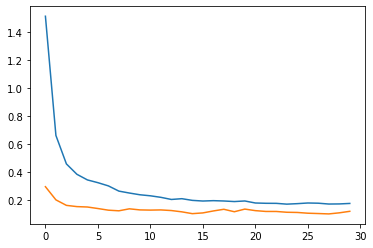

In [8]:
# visualizing losses and accuracy
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['sparse_categorical_accuracy']
val_acc    = history.history['val_sparse_categorical_accuracy']
xc         = range(epoch)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)

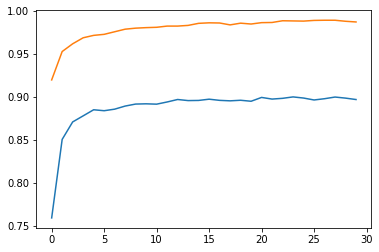

In [9]:
plt.figure()
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)

In [10]:
model.save("./model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model\assets


In [11]:
model_loaded = tf.keras.models.load_model('./model')

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1000200   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
Total params: 1,000,604
Trainable params: 1,000,604
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
print(model_loaded.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1000200   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
Total params: 1,000,604
Trainable params: 1,000,604
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
def pred(predictions, i):
    result = np.argmax(predictions[i])
    if result % 2 == 1:
        result = "Pass"
    else:
        result = "Stop"
    return result

In [15]:
import numpy as np

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`

predictions = model.predict(test_set[:])

for i in range(len(predictions)):
    print("{} : {}".format(i + 1, pred(predictions, i)))

Evaluate on test data
5000/5000 [==============================] - 0s 92us/sample - loss: 0.1176 - sparse_categorical_accuracy: 0.9872
test loss, test acc: [0.11755067134523843, 0.9872]
1 : Pass
2 : Pass
3 : Pass
4 : Pass
5 : Pass
6 : Pass
7 : Pass
8 : Pass
9 : Pass
10 : Pass
11 : Stop
12 : Pass
13 : Stop
14 : Pass
15 : Stop
16 : Pass
17 : Pass
18 : Pass
19 : Pass
20 : Pass
21 : Stop
22 : Stop
23 : Stop
24 : Stop
25 : Stop
26 : Stop
27 : Pass
28 : Stop
29 : Pass
30 : Stop
31 : Pass
32 : Pass
33 : Pass
34 : Pass
35 : Stop
36 : Pass
37 : Pass
38 : Pass
39 : Pass
40 : Pass
41 : Pass
42 : Pass
43 : Pass
44 : Pass
45 : Pass
46 : Pass
47 : Pass
48 : Pass
49 : Stop
50 : Stop
51 : Stop
52 : Pass
53 : Pass
54 : Stop
55 : Pass
56 : Stop
57 : Pass
58 : Stop
59 : Pass
60 : Pass
61 : Pass
62 : Pass
63 : Stop
64 : Pass
65 : Pass
66 : Pass
67 : Stop
68 : Pass
69 : Pass
70 : Pass
71 : Stop
72 : Pass
73 : Stop
74 : Pass
75 : Stop
76 : Pass
77 : Stop
78 : Pass
79 : Stop
80 : Pass
81 : Pass
82 : Stop
83 

1191 : Pass
1192 : Pass
1193 : Pass
1194 : Stop
1195 : Stop
1196 : Pass
1197 : Pass
1198 : Pass
1199 : Pass
1200 : Pass
1201 : Pass
1202 : Pass
1203 : Stop
1204 : Stop
1205 : Stop
1206 : Pass
1207 : Stop
1208 : Pass
1209 : Stop
1210 : Pass
1211 : Pass
1212 : Stop
1213 : Stop
1214 : Pass
1215 : Stop
1216 : Pass
1217 : Pass
1218 : Pass
1219 : Pass
1220 : Pass
1221 : Stop
1222 : Pass
1223 : Pass
1224 : Stop
1225 : Stop
1226 : Stop
1227 : Pass
1228 : Pass
1229 : Pass
1230 : Pass
1231 : Pass
1232 : Pass
1233 : Stop
1234 : Stop
1235 : Stop
1236 : Stop
1237 : Stop
1238 : Stop
1239 : Stop
1240 : Stop
1241 : Pass
1242 : Stop
1243 : Stop
1244 : Stop
1245 : Pass
1246 : Pass
1247 : Pass
1248 : Stop
1249 : Pass
1250 : Pass
1251 : Stop
1252 : Pass
1253 : Stop
1254 : Pass
1255 : Stop
1256 : Pass
1257 : Stop
1258 : Pass
1259 : Pass
1260 : Stop
1261 : Stop
1262 : Pass
1263 : Pass
1264 : Pass
1265 : Pass
1266 : Pass
1267 : Stop
1268 : Pass
1269 : Pass
1270 : Pass
1271 : Pass
1272 : Pass
1273 : Pass
1274

1938 : Pass
1939 : Pass
1940 : Pass
1941 : Pass
1942 : Stop
1943 : Pass
1944 : Pass
1945 : Stop
1946 : Pass
1947 : Pass
1948 : Stop
1949 : Pass
1950 : Pass
1951 : Stop
1952 : Pass
1953 : Pass
1954 : Stop
1955 : Pass
1956 : Pass
1957 : Stop
1958 : Stop
1959 : Stop
1960 : Pass
1961 : Stop
1962 : Stop
1963 : Pass
1964 : Stop
1965 : Pass
1966 : Stop
1967 : Stop
1968 : Pass
1969 : Stop
1970 : Pass
1971 : Pass
1972 : Pass
1973 : Stop
1974 : Pass
1975 : Pass
1976 : Pass
1977 : Pass
1978 : Pass
1979 : Pass
1980 : Pass
1981 : Pass
1982 : Stop
1983 : Pass
1984 : Pass
1985 : Pass
1986 : Pass
1987 : Pass
1988 : Pass
1989 : Stop
1990 : Pass
1991 : Stop
1992 : Pass
1993 : Pass
1994 : Pass
1995 : Pass
1996 : Pass
1997 : Pass
1998 : Stop
1999 : Pass
2000 : Stop
2001 : Stop
2002 : Pass
2003 : Stop
2004 : Stop
2005 : Pass
2006 : Stop
2007 : Pass
2008 : Pass
2009 : Pass
2010 : Pass
2011 : Stop
2012 : Pass
2013 : Pass
2014 : Pass
2015 : Pass
2016 : Stop
2017 : Pass
2018 : Pass
2019 : Stop
2020 : Pass
2021

2938 : Pass
2939 : Stop
2940 : Pass
2941 : Stop
2942 : Stop
2943 : Pass
2944 : Stop
2945 : Pass
2946 : Pass
2947 : Pass
2948 : Pass
2949 : Stop
2950 : Pass
2951 : Pass
2952 : Stop
2953 : Pass
2954 : Pass
2955 : Pass
2956 : Pass
2957 : Pass
2958 : Pass
2959 : Pass
2960 : Pass
2961 : Pass
2962 : Pass
2963 : Pass
2964 : Pass
2965 : Pass
2966 : Stop
2967 : Pass
2968 : Pass
2969 : Stop
2970 : Stop
2971 : Stop
2972 : Pass
2973 : Pass
2974 : Stop
2975 : Pass
2976 : Pass
2977 : Stop
2978 : Pass
2979 : Pass
2980 : Pass
2981 : Stop
2982 : Pass
2983 : Pass
2984 : Stop
2985 : Stop
2986 : Stop
2987 : Stop
2988 : Pass
2989 : Pass
2990 : Pass
2991 : Pass
2992 : Pass
2993 : Stop
2994 : Pass
2995 : Stop
2996 : Pass
2997 : Pass
2998 : Stop
2999 : Pass
3000 : Pass
3001 : Stop
3002 : Stop
3003 : Pass
3004 : Stop
3005 : Pass
3006 : Pass
3007 : Stop
3008 : Pass
3009 : Pass
3010 : Pass
3011 : Stop
3012 : Pass
3013 : Pass
3014 : Pass
3015 : Stop
3016 : Pass
3017 : Stop
3018 : Stop
3019 : Pass
3020 : Stop
3021

3937 : Pass
3938 : Pass
3939 : Stop
3940 : Pass
3941 : Pass
3942 : Stop
3943 : Pass
3944 : Pass
3945 : Pass
3946 : Pass
3947 : Pass
3948 : Stop
3949 : Stop
3950 : Pass
3951 : Stop
3952 : Pass
3953 : Stop
3954 : Stop
3955 : Pass
3956 : Stop
3957 : Stop
3958 : Pass
3959 : Pass
3960 : Pass
3961 : Stop
3962 : Pass
3963 : Pass
3964 : Stop
3965 : Stop
3966 : Stop
3967 : Pass
3968 : Pass
3969 : Stop
3970 : Stop
3971 : Pass
3972 : Stop
3973 : Pass
3974 : Pass
3975 : Pass
3976 : Pass
3977 : Stop
3978 : Pass
3979 : Stop
3980 : Pass
3981 : Pass
3982 : Pass
3983 : Pass
3984 : Pass
3985 : Pass
3986 : Pass
3987 : Pass
3988 : Pass
3989 : Pass
3990 : Stop
3991 : Pass
3992 : Pass
3993 : Pass
3994 : Pass
3995 : Pass
3996 : Pass
3997 : Pass
3998 : Pass
3999 : Pass
4000 : Pass
4001 : Stop
4002 : Stop
4003 : Pass
4004 : Pass
4005 : Stop
4006 : Stop
4007 : Pass
4008 : Stop
4009 : Pass
4010 : Pass
4011 : Stop
4012 : Stop
4013 : Pass
4014 : Stop
4015 : Stop
4016 : Stop
4017 : Pass
4018 : Pass
4019 : Stop
4020

4937 : Pass
4938 : Stop
4939 : Stop
4940 : Pass
4941 : Pass
4942 : Pass
4943 : Pass
4944 : Pass
4945 : Pass
4946 : Pass
4947 : Stop
4948 : Pass
4949 : Stop
4950 : Stop
4951 : Stop
4952 : Pass
4953 : Pass
4954 : Stop
4955 : Pass
4956 : Stop
4957 : Pass
4958 : Pass
4959 : Stop
4960 : Pass
4961 : Stop
4962 : Pass
4963 : Pass
4964 : Pass
4965 : Pass
4966 : Pass
4967 : Pass
4968 : Pass
4969 : Pass
4970 : Pass
4971 : Pass
4972 : Stop
4973 : Pass
4974 : Pass
4975 : Pass
4976 : Pass
4977 : Stop
4978 : Pass
4979 : Stop
4980 : Pass
4981 : Pass
4982 : Pass
4983 : Pass
4984 : Pass
4985 : Pass
4986 : Pass
4987 : Pass
4988 : Pass
4989 : Stop
4990 : Pass
4991 : Stop
4992 : Pass
4993 : Pass
4994 : Pass
4995 : Pass
4996 : Stop
4997 : Pass
4998 : Stop
4999 : Pass
5000 : Stop
5001 : Pass
5002 : Stop
5003 : Pass
5004 : Pass
5005 : Pass
5006 : Pass
5007 : Stop
5008 : Stop
5009 : Pass
5010 : Stop
5011 : Pass
5012 : Pass
5013 : Stop
5014 : Pass
5015 : Pass
5016 : Pass
5017 : Pass
5018 : Pass
5019 : Pass
5020

6305 : Stop
6306 : Pass
6307 : Pass
6308 : Stop
6309 : Pass
6310 : Pass
6311 : Pass
6312 : Pass
6313 : Stop
6314 : Pass
6315 : Pass
6316 : Pass
6317 : Stop
6318 : Pass
6319 : Pass
6320 : Pass
6321 : Pass
6322 : Pass
6323 : Stop
6324 : Stop
6325 : Pass
6326 : Stop
6327 : Stop
6328 : Stop
6329 : Pass
6330 : Pass
6331 : Stop
6332 : Stop
6333 : Pass
6334 : Pass
6335 : Stop
6336 : Pass
6337 : Pass
6338 : Pass
6339 : Stop
6340 : Pass
6341 : Pass
6342 : Pass
6343 : Pass
6344 : Stop
6345 : Pass
6346 : Pass
6347 : Pass
6348 : Pass
6349 : Stop
6350 : Pass
6351 : Pass
6352 : Pass
6353 : Pass
6354 : Stop
6355 : Pass
6356 : Pass
6357 : Pass
6358 : Stop
6359 : Pass
6360 : Pass
6361 : Stop
6362 : Pass
6363 : Pass
6364 : Pass
6365 : Pass
6366 : Pass
6367 : Stop
6368 : Pass
6369 : Pass
6370 : Pass
6371 : Stop
6372 : Stop
6373 : Stop
6374 : Pass
6375 : Pass
6376 : Pass
6377 : Stop
6378 : Pass
6379 : Pass
6380 : Pass
6381 : Pass
6382 : Pass
6383 : Pass
6384 : Stop
6385 : Stop
6386 : Pass
6387 : Stop
6388

7365 : Stop
7366 : Stop
7367 : Pass
7368 : Stop
7369 : Stop
7370 : Stop
7371 : Pass
7372 : Stop
7373 : Pass
7374 : Pass
7375 : Pass
7376 : Pass
7377 : Pass
7378 : Pass
7379 : Pass
7380 : Pass
7381 : Pass
7382 : Pass
7383 : Pass
7384 : Pass
7385 : Pass
7386 : Pass
7387 : Pass
7388 : Pass
7389 : Pass
7390 : Pass
7391 : Pass
7392 : Pass
7393 : Stop
7394 : Pass
7395 : Pass
7396 : Pass
7397 : Pass
7398 : Stop
7399 : Stop
7400 : Stop
7401 : Pass
7402 : Pass
7403 : Pass
7404 : Pass
7405 : Stop
7406 : Pass
7407 : Stop
7408 : Pass
7409 : Pass
7410 : Pass
7411 : Stop
7412 : Pass
7413 : Stop
7414 : Pass
7415 : Pass
7416 : Pass
7417 : Pass
7418 : Pass
7419 : Pass
7420 : Pass
7421 : Pass
7422 : Stop
7423 : Pass
7424 : Pass
7425 : Stop
7426 : Pass
7427 : Pass
7428 : Pass
7429 : Pass
7430 : Stop
7431 : Pass
7432 : Pass
7433 : Pass
7434 : Pass
7435 : Stop
7436 : Pass
7437 : Pass
7438 : Pass
7439 : Pass
7440 : Pass
7441 : Stop
7442 : Stop
7443 : Pass
7444 : Pass
7445 : Stop
7446 : Pass
7447 : Pass
7448

8788 : Pass
8789 : Stop
8790 : Pass
8791 : Stop
8792 : Pass
8793 : Pass
8794 : Pass
8795 : Stop
8796 : Pass
8797 : Pass
8798 : Pass
8799 : Stop
8800 : Pass
8801 : Pass
8802 : Stop
8803 : Pass
8804 : Pass
8805 : Pass
8806 : Stop
8807 : Pass
8808 : Pass
8809 : Stop
8810 : Stop
8811 : Stop
8812 : Pass
8813 : Pass
8814 : Pass
8815 : Pass
8816 : Pass
8817 : Stop
8818 : Pass
8819 : Pass
8820 : Stop
8821 : Pass
8822 : Stop
8823 : Pass
8824 : Pass
8825 : Pass
8826 : Pass
8827 : Pass
8828 : Stop
8829 : Stop
8830 : Pass
8831 : Pass
8832 : Stop
8833 : Pass
8834 : Pass
8835 : Stop
8836 : Pass
8837 : Pass
8838 : Stop
8839 : Pass
8840 : Pass
8841 : Pass
8842 : Pass
8843 : Stop
8844 : Pass
8845 : Pass
8846 : Pass
8847 : Stop
8848 : Pass
8849 : Stop
8850 : Pass
8851 : Stop
8852 : Pass
8853 : Pass
8854 : Stop
8855 : Pass
8856 : Pass
8857 : Pass
8858 : Pass
8859 : Pass
8860 : Pass
8861 : Pass
8862 : Pass
8863 : Pass
8864 : Pass
8865 : Pass
8866 : Stop
8867 : Pass
8868 : Pass
8869 : Pass
8870 : Pass
8871

10852 : Stop
10853 : Pass
10854 : Pass
10855 : Pass
10856 : Stop
10857 : Pass
10858 : Pass
10859 : Pass
10860 : Pass
10861 : Stop
10862 : Stop
10863 : Pass
10864 : Pass
10865 : Pass
10866 : Pass
10867 : Pass
10868 : Pass
10869 : Stop
10870 : Pass
10871 : Pass
10872 : Stop
10873 : Pass
10874 : Pass
10875 : Pass
10876 : Stop
10877 : Pass
10878 : Stop
10879 : Pass
10880 : Pass
10881 : Stop
10882 : Pass
10883 : Stop
10884 : Pass
10885 : Pass
10886 : Pass
10887 : Pass
10888 : Stop
10889 : Pass
10890 : Pass
10891 : Pass
10892 : Pass
10893 : Pass
10894 : Stop
10895 : Pass
10896 : Stop
10897 : Stop
10898 : Stop
10899 : Pass
10900 : Pass
10901 : Pass
10902 : Stop
10903 : Stop
10904 : Pass
10905 : Pass
10906 : Pass
10907 : Pass
10908 : Pass
10909 : Pass
10910 : Pass
10911 : Pass
10912 : Pass
10913 : Pass
10914 : Stop
10915 : Pass
10916 : Pass
10917 : Stop
10918 : Pass
10919 : Stop
10920 : Pass
10921 : Pass
10922 : Stop
10923 : Pass
10924 : Pass
10925 : Stop
10926 : Pass
10927 : Stop
10928 : Stop

12434 : Pass
12435 : Stop
12436 : Pass
12437 : Pass
12438 : Pass
12439 : Pass
12440 : Pass
12441 : Pass
12442 : Pass
12443 : Pass
12444 : Stop
12445 : Stop
12446 : Stop
12447 : Pass
12448 : Pass
12449 : Stop
12450 : Pass
12451 : Pass
12452 : Pass
12453 : Pass
12454 : Pass
12455 : Pass
12456 : Pass
12457 : Stop
12458 : Pass
12459 : Pass
12460 : Stop
12461 : Stop
12462 : Stop
12463 : Pass
12464 : Pass
12465 : Pass
12466 : Stop
12467 : Pass
12468 : Stop
12469 : Stop
12470 : Pass
12471 : Pass
12472 : Pass
12473 : Pass
12474 : Pass
12475 : Stop
12476 : Pass
12477 : Pass
12478 : Pass
12479 : Stop
12480 : Pass
12481 : Stop
12482 : Pass
12483 : Pass
12484 : Pass
12485 : Stop
12486 : Pass
12487 : Stop
12488 : Pass
12489 : Pass
12490 : Stop
12491 : Stop
12492 : Stop
12493 : Pass
12494 : Pass
12495 : Pass
12496 : Pass
12497 : Pass
12498 : Pass
12499 : Stop
12500 : Pass
12501 : Pass
12502 : Pass
12503 : Pass
12504 : Stop
12505 : Stop
12506 : Pass
12507 : Pass
12508 : Pass
12509 : Pass
12510 : Pass

13795 : Pass
13796 : Stop
13797 : Pass
13798 : Pass
13799 : Pass
13800 : Pass
13801 : Pass
13802 : Pass
13803 : Pass
13804 : Pass
13805 : Pass
13806 : Pass
13807 : Stop
13808 : Pass
13809 : Stop
13810 : Pass
13811 : Pass
13812 : Pass
13813 : Pass
13814 : Pass
13815 : Pass
13816 : Pass
13817 : Pass
13818 : Pass
13819 : Stop
13820 : Stop
13821 : Pass
13822 : Stop
13823 : Pass
13824 : Stop
13825 : Pass
13826 : Stop
13827 : Pass
13828 : Stop
13829 : Pass
13830 : Pass
13831 : Pass
13832 : Stop
13833 : Stop
13834 : Pass
13835 : Pass
13836 : Pass
13837 : Pass
13838 : Stop
13839 : Pass
13840 : Pass
13841 : Pass
13842 : Stop
13843 : Pass
13844 : Pass
13845 : Stop
13846 : Pass
13847 : Stop
13848 : Stop
13849 : Stop
13850 : Stop
13851 : Pass
13852 : Pass
13853 : Pass
13854 : Stop
13855 : Pass
13856 : Stop
13857 : Pass
13858 : Pass
13859 : Pass
13860 : Pass
13861 : Pass
13862 : Stop
13863 : Pass
13864 : Pass
13865 : Pass
13866 : Pass
13867 : Pass
13868 : Stop
13869 : Pass
13870 : Stop
13871 : Pass

15134 : Stop
15135 : Pass
15136 : Pass
15137 : Pass
15138 : Stop
15139 : Pass
15140 : Pass
15141 : Stop
15142 : Pass
15143 : Pass
15144 : Pass
15145 : Stop
15146 : Pass
15147 : Pass
15148 : Pass
15149 : Pass
15150 : Pass
15151 : Stop
15152 : Pass
15153 : Pass
15154 : Pass
15155 : Stop
15156 : Stop
15157 : Pass
15158 : Pass
15159 : Pass
15160 : Pass
15161 : Stop
15162 : Stop
15163 : Pass
15164 : Pass
15165 : Pass
15166 : Stop
15167 : Stop
15168 : Pass
15169 : Pass
15170 : Stop
15171 : Stop
15172 : Pass
15173 : Pass
15174 : Pass
15175 : Pass
15176 : Stop
15177 : Pass
15178 : Stop
15179 : Pass
15180 : Stop
15181 : Stop
15182 : Pass
15183 : Stop
15184 : Pass
15185 : Pass
15186 : Pass
15187 : Stop
15188 : Pass
15189 : Stop
15190 : Pass
15191 : Stop
15192 : Stop
15193 : Pass
15194 : Pass
15195 : Stop
15196 : Pass
15197 : Pass
15198 : Pass
15199 : Pass
15200 : Stop
15201 : Pass
15202 : Pass
15203 : Stop
15204 : Pass
15205 : Stop
15206 : Stop
15207 : Pass
15208 : Pass
15209 : Pass
15210 : Pass

16561 : Pass
16562 : Pass
16563 : Pass
16564 : Pass
16565 : Stop
16566 : Pass
16567 : Pass
16568 : Stop
16569 : Stop
16570 : Pass
16571 : Stop
16572 : Pass
16573 : Pass
16574 : Stop
16575 : Pass
16576 : Pass
16577 : Stop
16578 : Pass
16579 : Pass
16580 : Pass
16581 : Pass
16582 : Pass
16583 : Stop
16584 : Stop
16585 : Pass
16586 : Stop
16587 : Pass
16588 : Pass
16589 : Pass
16590 : Pass
16591 : Stop
16592 : Pass
16593 : Pass
16594 : Pass
16595 : Pass
16596 : Pass
16597 : Pass
16598 : Pass
16599 : Pass
16600 : Pass
16601 : Pass
16602 : Stop
16603 : Stop
16604 : Pass
16605 : Pass
16606 : Pass
16607 : Stop
16608 : Pass
16609 : Stop
16610 : Pass
16611 : Pass
16612 : Pass
16613 : Stop
16614 : Stop
16615 : Pass
16616 : Pass
16617 : Pass
16618 : Pass
16619 : Pass
16620 : Pass
16621 : Pass
16622 : Pass
16623 : Stop
16624 : Pass
16625 : Pass
16626 : Pass
16627 : Pass
16628 : Pass
16629 : Stop
16630 : Pass
16631 : Pass
16632 : Pass
16633 : Pass
16634 : Stop
16635 : Stop
16636 : Pass
16637 : Stop

18194 : Stop
18195 : Stop
18196 : Pass
18197 : Pass
18198 : Stop
18199 : Pass
18200 : Pass
18201 : Pass
18202 : Pass
18203 : Pass
18204 : Pass
18205 : Pass
18206 : Stop
18207 : Pass
18208 : Stop
18209 : Stop
18210 : Pass
18211 : Pass
18212 : Pass
18213 : Pass
18214 : Pass
18215 : Pass
18216 : Stop
18217 : Pass
18218 : Pass
18219 : Pass
18220 : Pass
18221 : Pass
18222 : Stop
18223 : Stop
18224 : Pass
18225 : Pass
18226 : Pass
18227 : Stop
18228 : Stop
18229 : Stop
18230 : Pass
18231 : Pass
18232 : Stop
18233 : Stop
18234 : Pass
18235 : Stop
18236 : Stop
18237 : Pass
18238 : Pass
18239 : Pass
18240 : Stop
18241 : Pass
18242 : Pass
18243 : Pass
18244 : Pass
18245 : Stop
18246 : Pass
18247 : Pass
18248 : Stop
18249 : Pass
18250 : Pass
18251 : Stop
18252 : Stop
18253 : Pass
18254 : Pass
18255 : Stop
18256 : Pass
18257 : Stop
18258 : Pass
18259 : Pass
18260 : Pass
18261 : Pass
18262 : Stop
18263 : Stop
18264 : Pass
18265 : Pass
18266 : Stop
18267 : Pass
18268 : Stop
18269 : Pass
18270 : Stop

19432 : Stop
19433 : Pass
19434 : Pass
19435 : Pass
19436 : Pass
19437 : Pass
19438 : Stop
19439 : Stop
19440 : Pass
19441 : Pass
19442 : Pass
19443 : Pass
19444 : Pass
19445 : Pass
19446 : Stop
19447 : Pass
19448 : Pass
19449 : Pass
19450 : Pass
19451 : Pass
19452 : Stop
19453 : Pass
19454 : Pass
19455 : Pass
19456 : Pass
19457 : Pass
19458 : Pass
19459 : Pass
19460 : Stop
19461 : Pass
19462 : Pass
19463 : Pass
19464 : Pass
19465 : Stop
19466 : Pass
19467 : Pass
19468 : Stop
19469 : Stop
19470 : Pass
19471 : Stop
19472 : Pass
19473 : Pass
19474 : Pass
19475 : Pass
19476 : Pass
19477 : Pass
19478 : Pass
19479 : Pass
19480 : Stop
19481 : Pass
19482 : Stop
19483 : Stop
19484 : Pass
19485 : Pass
19486 : Pass
19487 : Pass
19488 : Pass
19489 : Pass
19490 : Stop
19491 : Pass
19492 : Pass
19493 : Pass
19494 : Pass
19495 : Pass
19496 : Pass
19497 : Stop
19498 : Pass
19499 : Pass
19500 : Pass
19501 : Pass
19502 : Pass
19503 : Pass
19504 : Pass
19505 : Pass
19506 : Pass
19507 : Stop
19508 : Pass

20503 : Pass
20504 : Stop
20505 : Pass
20506 : Stop
20507 : Pass
20508 : Pass
20509 : Pass
20510 : Pass
20511 : Pass
20512 : Pass
20513 : Pass
20514 : Pass
20515 : Pass
20516 : Pass
20517 : Pass
20518 : Pass
20519 : Stop
20520 : Pass
20521 : Stop
20522 : Pass
20523 : Stop
20524 : Pass
20525 : Pass
20526 : Pass
20527 : Stop
20528 : Pass
20529 : Pass
20530 : Pass
20531 : Pass
20532 : Pass
20533 : Pass
20534 : Pass
20535 : Pass
20536 : Pass
20537 : Pass
20538 : Stop
20539 : Pass
20540 : Pass
20541 : Pass
20542 : Stop
20543 : Pass
20544 : Stop
20545 : Pass
20546 : Pass
20547 : Pass
20548 : Pass
20549 : Pass
20550 : Pass
20551 : Stop
20552 : Pass
20553 : Pass
20554 : Stop
20555 : Pass
20556 : Pass
20557 : Pass
20558 : Stop
20559 : Stop
20560 : Pass
20561 : Stop
20562 : Stop
20563 : Pass
20564 : Pass
20565 : Pass
20566 : Pass
20567 : Stop
20568 : Pass
20569 : Pass
20570 : Pass
20571 : Stop
20572 : Pass
20573 : Pass
20574 : Stop
20575 : Stop
20576 : Pass
20577 : Stop
20578 : Pass
20579 : Pass

21636 : Pass
21637 : Pass
21638 : Pass
21639 : Stop
21640 : Pass
21641 : Pass
21642 : Pass
21643 : Stop
21644 : Pass
21645 : Pass
21646 : Stop
21647 : Pass
21648 : Stop
21649 : Pass
21650 : Pass
21651 : Pass
21652 : Stop
21653 : Pass
21654 : Pass
21655 : Pass
21656 : Pass
21657 : Pass
21658 : Stop
21659 : Pass
21660 : Pass
21661 : Stop
21662 : Pass
21663 : Stop
21664 : Pass
21665 : Pass
21666 : Stop
21667 : Stop
21668 : Stop
21669 : Pass
21670 : Pass
21671 : Stop
21672 : Pass
21673 : Pass
21674 : Pass
21675 : Pass
21676 : Pass
21677 : Pass
21678 : Pass
21679 : Stop
21680 : Stop
21681 : Pass
21682 : Pass
21683 : Pass
21684 : Stop
21685 : Stop
21686 : Pass
21687 : Pass
21688 : Stop
21689 : Stop
21690 : Pass
21691 : Pass
21692 : Pass
21693 : Pass
21694 : Pass
21695 : Pass
21696 : Pass
21697 : Pass
21698 : Pass
21699 : Pass
21700 : Pass
21701 : Pass
21702 : Pass
21703 : Pass
21704 : Pass
21705 : Pass
21706 : Pass
21707 : Pass
21708 : Pass
21709 : Pass
21710 : Pass
21711 : Pass
21712 : Stop

22898 : Pass
22899 : Pass
22900 : Pass
22901 : Pass
22902 : Stop
22903 : Pass
22904 : Pass
22905 : Stop
22906 : Pass
22907 : Pass
22908 : Pass
22909 : Stop
22910 : Pass
22911 : Stop
22912 : Pass
22913 : Stop
22914 : Pass
22915 : Pass
22916 : Pass
22917 : Pass
22918 : Stop
22919 : Stop
22920 : Pass
22921 : Pass
22922 : Pass
22923 : Pass
22924 : Pass
22925 : Pass
22926 : Pass
22927 : Pass
22928 : Pass
22929 : Pass
22930 : Pass
22931 : Pass
22932 : Stop
22933 : Pass
22934 : Pass
22935 : Pass
22936 : Pass
22937 : Stop
22938 : Pass
22939 : Stop
22940 : Pass
22941 : Pass
22942 : Pass
22943 : Pass
22944 : Pass
22945 : Stop
22946 : Pass
22947 : Pass
22948 : Stop
22949 : Pass
22950 : Pass
22951 : Stop
22952 : Stop
22953 : Pass
22954 : Pass
22955 : Pass
22956 : Pass
22957 : Pass
22958 : Pass
22959 : Stop
22960 : Pass
22961 : Stop
22962 : Pass
22963 : Pass
22964 : Pass
22965 : Pass
22966 : Stop
22967 : Pass
22968 : Pass
22969 : Pass
22970 : Stop
22971 : Stop
22972 : Pass
22973 : Pass
22974 : Pass

23755 : Pass
23756 : Pass
23757 : Pass
23758 : Stop
23759 : Pass
23760 : Pass
23761 : Pass
23762 : Pass
23763 : Pass
23764 : Pass
23765 : Pass
23766 : Pass
23767 : Pass
23768 : Pass
23769 : Pass
23770 : Pass
23771 : Pass
23772 : Pass
23773 : Stop
23774 : Pass
23775 : Stop
23776 : Pass
23777 : Pass
23778 : Stop
23779 : Pass
23780 : Pass
23781 : Stop
23782 : Pass
23783 : Pass
23784 : Pass
23785 : Stop
23786 : Pass
23787 : Pass
23788 : Pass
23789 : Pass
23790 : Pass
23791 : Stop
23792 : Stop
23793 : Stop
23794 : Stop
23795 : Stop
23796 : Pass
23797 : Pass
23798 : Pass
23799 : Pass
23800 : Stop
23801 : Pass
23802 : Pass
23803 : Pass
23804 : Pass
23805 : Pass
23806 : Pass
23807 : Pass
23808 : Stop
23809 : Pass
23810 : Pass
23811 : Pass
23812 : Pass
23813 : Stop
23814 : Pass
23815 : Pass
23816 : Stop
23817 : Pass
23818 : Stop
23819 : Pass
23820 : Pass
23821 : Pass
23822 : Stop
23823 : Pass
23824 : Pass
23825 : Stop
23826 : Pass
23827 : Pass
23828 : Stop
23829 : Pass
23830 : Pass
23831 : Stop

24429 : Pass
24430 : Pass
24431 : Pass
24432 : Pass
24433 : Stop
24434 : Pass
24435 : Pass
24436 : Pass
24437 : Pass
24438 : Pass
24439 : Pass
24440 : Stop
24441 : Pass
24442 : Stop
24443 : Pass
24444 : Stop
24445 : Stop
24446 : Pass
24447 : Pass
24448 : Pass
24449 : Stop
24450 : Pass
24451 : Pass
24452 : Pass
24453 : Stop
24454 : Pass
24455 : Pass
24456 : Pass
24457 : Stop
24458 : Stop
24459 : Stop
24460 : Stop
24461 : Stop
24462 : Pass
24463 : Pass
24464 : Pass
24465 : Pass
24466 : Stop
24467 : Stop
24468 : Stop
24469 : Pass
24470 : Pass
24471 : Pass
24472 : Pass
24473 : Pass
24474 : Pass
24475 : Pass
24476 : Pass
24477 : Pass
24478 : Stop
24479 : Pass
24480 : Stop
24481 : Stop
24482 : Pass
24483 : Pass
24484 : Pass
24485 : Pass
24486 : Pass
24487 : Pass
24488 : Stop
24489 : Pass
24490 : Pass
24491 : Pass
24492 : Stop
24493 : Pass
24494 : Stop
24495 : Pass
24496 : Stop
24497 : Pass
24498 : Pass
24499 : Pass
24500 : Stop
24501 : Pass
24502 : Pass
24503 : Stop
24504 : Pass
24505 : Pass

25149 : Stop
25150 : Stop
25151 : Stop
25152 : Stop
25153 : Stop
25154 : Stop
25155 : Stop
25156 : Stop
25157 : Stop
25158 : Stop
25159 : Stop
25160 : Stop
25161 : Stop
25162 : Stop
25163 : Stop
25164 : Stop
25165 : Stop
25166 : Stop
25167 : Stop
25168 : Stop
25169 : Stop
25170 : Stop
25171 : Stop
25172 : Stop
25173 : Stop
25174 : Stop
25175 : Stop
25176 : Stop
25177 : Stop
25178 : Stop
25179 : Stop
25180 : Stop
25181 : Stop
25182 : Stop
25183 : Stop
25184 : Stop
25185 : Stop
25186 : Stop
25187 : Stop
25188 : Stop
25189 : Stop
25190 : Stop
25191 : Stop
25192 : Stop
25193 : Stop
25194 : Stop
25195 : Stop
25196 : Stop
25197 : Stop
25198 : Stop
25199 : Stop
25200 : Stop
25201 : Stop
25202 : Stop
25203 : Stop
25204 : Stop
25205 : Stop
25206 : Stop
25207 : Stop
25208 : Stop
25209 : Stop
25210 : Stop
25211 : Stop
25212 : Stop
25213 : Stop
25214 : Stop
25215 : Stop
25216 : Stop
25217 : Pass
25218 : Stop
25219 : Pass
25220 : Pass
25221 : Stop
25222 : Stop
25223 : Stop
25224 : Stop
25225 : Stop